In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb


In [3]:

generation = pd.read_csv("datasets/Generacion_fotovoltaica.csv", sep=",")

In [4]:
# Rename columns to Prophet defaults
generation.rename(columns={'FECHA': 'ds', 'TOTAL_KWH_ENERGIA': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
generation['ds'] = pd.to_datetime(generation['ds'])

# Augment the dataset with year, month, day, and hour
generation['year'] = generation['ds'].dt.year
generation['month'] = generation['ds'].dt.month
generation['day'] = generation['ds'].dt.day
generation['hour'] = generation['ds'].dt.hour

# Note: Extracting the day of the week (0-6, where 0 is Monday)
generation['weekday'] = generation['ds'].dt.weekday

generation['is_weekend'] = (generation['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

#Augmented dataset
generation = generation[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
generation['y'] = generation['y'].clip(lower=0)


generation

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,NaN
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.66
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.98
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.35
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.90
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,NaN
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,NaN
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,NaN
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,NaN


In [5]:
sum(generation['y'].isnull())

1164

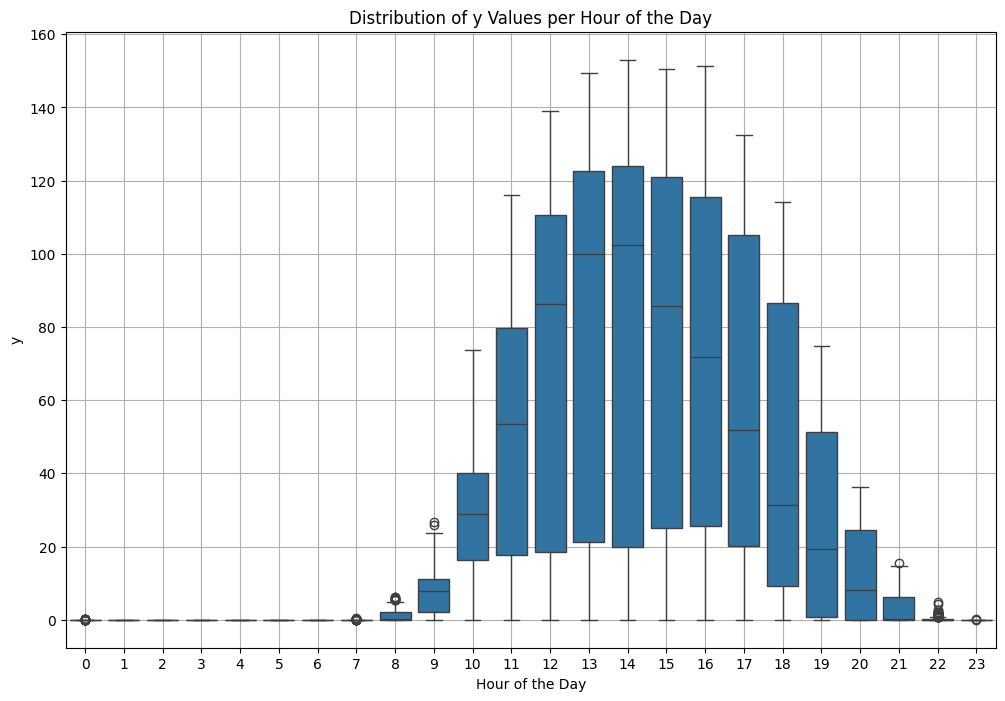

In [6]:


# Plot the distribution of 'y' values per hour
plt.figure(figsize=(12, 8))
sns.boxplot(x='hour', y='y', data=generation)
plt.xlabel('Hour of the Day')
plt.ylabel('y')
plt.title('Distribution of y Values per Hour of the Day')
plt.grid(True)
plt.show()

#We can clip all the values that are within the hours 22 to 7 to 0


In [7]:
# Impute null values to 0 for the specified hours
generation.loc[generation['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7]) & generation['y'].isnull(), 'y'] = 0

print(sum(generation['y'].isnull()))


699


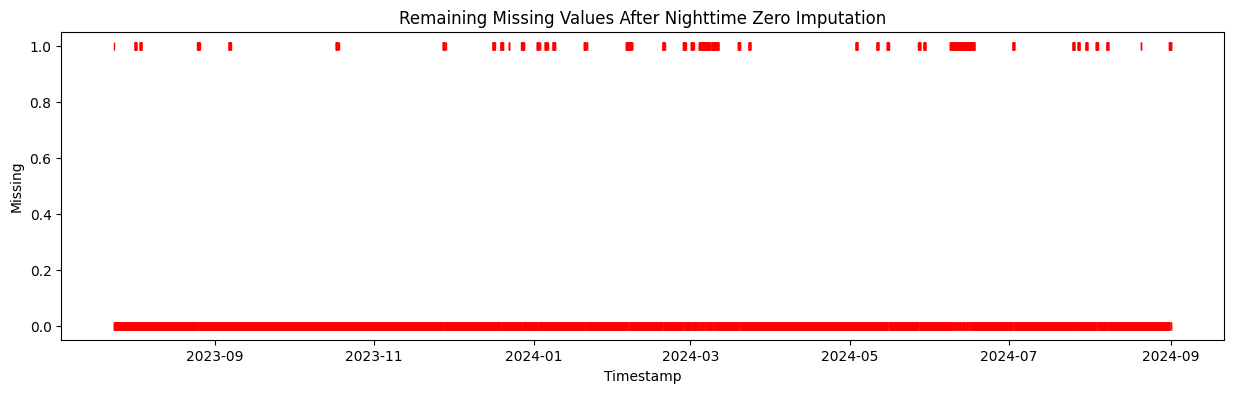

In [8]:


# Create a boolean mask of missing values
missing_mask = generation['y'].isna()

# Plot missing values over time
plt.figure(figsize=(15, 4))
plt.plot(generation['ds'], missing_mask, '|', color='red')
plt.title('Remaining Missing Values After Nighttime Zero Imputation')
plt.xlabel('Timestamp')
plt.ylabel('Missing')
plt.show()


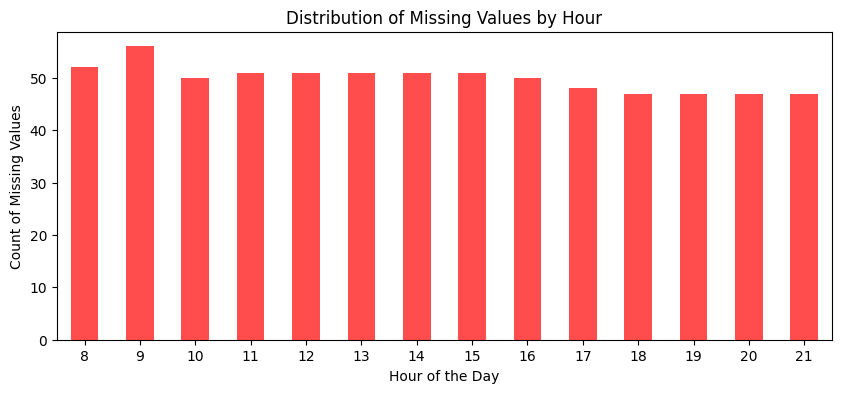

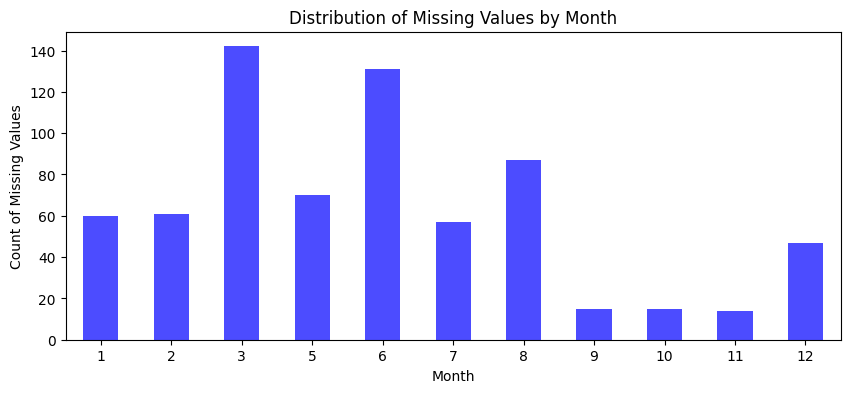

In [9]:

# Load the dataset (assuming it's already in memory)
df = generation.copy()

# Filter for remaining NaNs after zero imputation
df_missing = df[df['y'].isna()]

# Plot missing values by hour
plt.figure(figsize=(10, 4))
df_missing['hour'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.7)
plt.title('Distribution of Missing Values by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.show()

# Plot missing values by month
plt.figure(figsize=(10, 4))
df_missing['month'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Distribution of Missing Values by Month')
plt.xlabel('Month')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.show()

#Maybe we can also set values to 0 seasonally speaking (in fall and winter sundown is at 19)


In [10]:
potential_na_fix = generation[generation['y'].isna() & generation['month'].isin([10, 11, 12, 1, 2]) & generation['hour'].isin([19,20,21,8])]
len(potential_na_fix)

53

In [11]:

# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Select the columns to impute
columns_to_impute = ['y']

# Apply the imputer to the 'y' column
generation[columns_to_impute] = imputer.fit_transform(generation[columns_to_impute])

In [12]:
generation.isna().sum()

ds            0
year          0
month         0
day           0
weekday       0
is_weekend    0
hour          0
y             0
dtype: int64

## Extra Features

In [13]:
# Cyclical Encoding
generation['hour_sin'] = np.sin(2 * np.pi * generation['hour'] / 24)
generation['hour_cos'] = np.cos(2 * np.pi * generation['hour'] / 24)

generation['day_sin'] = np.sin(2 * np.pi * generation['day'] / 31)
generation['day_cos'] = np.cos(2 * np.pi * generation['day'] / 31)

generation['month_sin'] = np.sin(2 * np.pi * generation['month'] / 12)
generation['month_cos'] = np.cos(2 * np.pi * generation['month'] / 12)

In [14]:
# Create Lag Features (E.g: last 1 hour, last 24 hours)
generation = generation.sort_values(by=['ds'])  # Ensure Correct Ordering

generation['Energia_lag1'] = generation['y'].shift(1)
generation['Energia_lag24'] = generation['y'].shift(24)

generation['Energia_lag3'] = generation['y'].shift(3)  # 3 hours ago
generation['Energia_lag4'] = generation['y'].shift(4)  # 4 hours ago
generation['Energia_lag5'] = generation['y'].shift(5)  # 5 hours ago

generation['Energia_lag2'] = generation['y'].shift(2)  # 2 hours ago
generation['Energia_lag6'] = generation['y'].shift(6)  # 6 hours ago
generation['Energia_lag12'] = generation['y'].shift(12)  # 12 hours ago
generation['Energia_lag168'] = generation['y'].shift(168)  # 7 days ago (24 * 7)

In [15]:
# Rolling Window Features
df['Energia_rolling8'] = df['y'].rolling(8).mean().reset_index(level=0, drop=True)

df['Energia_rolling16'] = df['y'].rolling(16).mean().reset_index(level=0, drop=True)
df['Energia_rolling6'] = df['y'].rolling(6).mean().reset_index(level=0, drop=True)
df['Energia_rolling12'] = df['y'].rolling(12).mean().reset_index(level=0, drop=True)
df['Energia_rolling24'] = df['y'].rolling(24).mean().reset_index(level=0, drop=True)
df['Energia_rolling32'] = df['y'].rolling(32).mean().reset_index(level=0, drop=True)
df['Energia_rolling48'] = df['y'].rolling(48).mean().reset_index(level=0, drop=True)

In [16]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-07-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

# Drop unnecessary columns for training
X_train = train_df.drop(columns=['ds', 'y'])
X_test = test_df.drop(columns=['ds', 'y'])
# fechaHora is the timestamp and should not be a predictor


# Ensuring y_train contain only the target variable
y_train = train_df['y']
y_test = test_df['y']

# Print dataset shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (8941, 21), Test shape: (767, 21)


In [17]:
# Install XGBoost if not installed
%pip install xgboost scikit-learn optuna --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Define the XGBoost model -> No hyperparameter tuning yet
model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=200,              
    learning_rate=0.05,            
    max_depth=6,                   
    subsample=0.8,                 
    colsample_bytree=0.8,          
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4%}")

Mean Absolute Error (MAE): 4.7603
Mean Absolute Percentage Error (MAPE): 70088056745307952.0000%


In [20]:
#SMAPE

def smape(y_true, y_pred):
    return 100 * (2 * abs(y_pred - y_true) / (abs(y_true) + abs(y_pred) + 1e-8)).mean()

smape_value = smape(y_test, y_pred)
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.4f}%")

Symmetric Mean Absolute Percentage Error (SMAPE): 95.9445%


In [21]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from optuna.samplers import RandomSampler, TPESampler

# Objective function for Optuna optimization
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'objective': 'reg:squarederror',
        'random_state': 42,
    }
    
    # Initialize cross-validation strategy
    tscv = TimeSeriesSplit(n_splits=4) 
    
    mae_scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train model
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train_fold, y_train_fold, 
            eval_set=[(X_val_fold, y_val_fold)], 
            verbose=False
        )
        
        # Predict
        y_pred = model.predict(X_val_fold)
        
        # Evaluate using MAE
        mae = mean_absolute_error(y_val_fold, y_pred)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)  # Return average MAE across folds


run = True
if run:

    # Step 1: Run 75 Random Trials
    study = optuna.create_study(direction='minimize', sampler=RandomSampler())
    study.optimize(objective, n_trials=50, n_jobs=-1)

    # Step 2: Switch to TPE Sampler for the next 75 trials
    study.sampler = TPESampler()  # Change sampler
    study.optimize(objective, n_trials=50, n_jobs=-1)

    # Get best parameters
    best_params = study.best_params
    print(f"Best Parameters: {best_params}")


c:\Users\juanf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-22 15:52:43,748] A new study created in memory with name: no-name-f5e5622c-6627-440b-ab60-9fecd098045f
[I 2025-03-22 15:52:46,384] Trial 8 finished with value: 5.693133775881108 and parameters: {'n_estimators': 100, 'learning_rate': 0.11022077793881595, 'max_depth': 3, 'subsample': 0.6173294641951278, 'colsample_bytree': 0.6570713087668759, 'reg_alpha': 6.477634225886975, 'reg_lambda': 1.55882240498057, 'min_child_weight': 4, 'gamma': 3.5063989525173955}. Best is trial 8 with value: 5.693133775881108.
[I 2025-03-22 15:52:48,571] Trial 2 finished with value: 5.310928458324627 and parameters: {'n_estimators': 100, 'learning_rate': 0.046467981763973355, 'max_depth': 7, 'subsample': 0.6089712141379768, 'co

Best Parameters: {'n_estimators': 150, 'learning_rate': 0.05015620007693519, 'max_depth': 8, 'subsample': 0.8579899757901963, 'colsample_bytree': 0.9213798250286502, 'reg_alpha': 8.07853995523152, 'reg_lambda': 3.2236910933146605, 'min_child_weight': 10, 'gamma': 2.080350206499059}


In [22]:
optimized_model = xgb.XGBRegressor(**best_params)

# Train the model with optimized parameters
optimized_model.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9213798250286502, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.080350206499059,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05015620007693519,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
# Predict on test set
y_pred = optimized_model.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4%}")

smape_value = smape(y_test, y_pred)
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.4f}%")




Mean Absolute Error (MAE): 4.5593
Mean Absolute Percentage Error (MAPE): 60818493659772048.0000%
Symmetric Mean Absolute Percentage Error (SMAPE): 94.2034%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

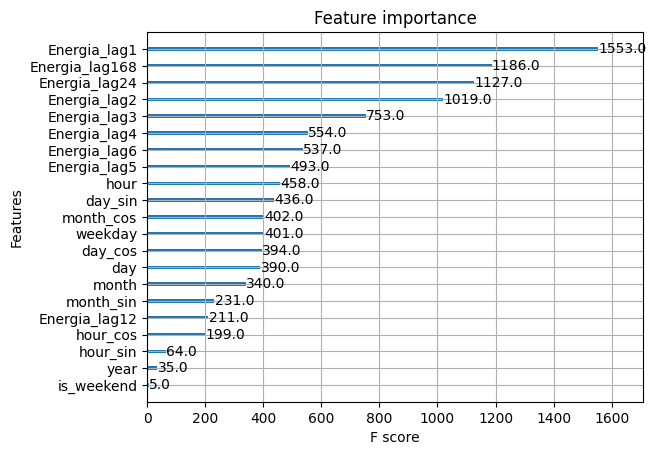

In [24]:
xgb.plot_importance(optimized_model)

In [25]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-08-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

# Drop unnecessary columns for training
X_train = train_df.drop(columns=['ds', 'y'])
X_test = test_df.drop(columns=['ds', 'y'])
# fechaHora is the timestamp and should not be a predictor


# Ensuring y_train contain only the target variable
y_train = train_df['y']
y_test = test_df['y']

In [26]:
# Generate timestamps for September
future_dates = pd.date_range(start='2024-09-01 00:00:00', end='2024-09-30 23:00:00', freq='h')

# Create an empty DataFrame for predictions
future_df = pd.DataFrame({'ds': future_dates})

# Convert Timestamp Features
future_df['hour'] = future_df['ds'].dt.hour
future_df['day'] = future_df['ds'].dt.day
future_df['month'] = future_df['ds'].dt.month
future_df['weekday'] = future_df['ds'].dt.weekday
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)

# Apply Cyclical Encoding
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)

future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)

future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)

last_known_data = df[df['ds'] >= '2024-08-31'].copy()


In [27]:
feature_columns = X_train.columns.tolist()

# Ensure all required columns exist in `future_df`
missing_cols = set(X_train.columns) - set(future_df.columns)
print("Missing Columns Before Prediction Loop:", missing_cols)

for col in missing_cols:
    future_df[col] = np.nan  # Initialize with NaN
    
predictions = []
for i in range(len(future_df)):
    row = future_df.iloc[i].copy()

    # Handle missing lag values (e.g., first few hours)
    row = row.ffill()  # Forward-fill missing values

    # Predict Energia
    row_features = row[feature_columns].values.reshape(1, -1)
    pred = optimized_model.predict(row_features)[0]

    # Store the prediction
    predictions.append(pred)
    future_df.at[i, 'Energia'] = pred  

    # Dynamically update lag features
    for lag in [1, 2, 3, 4, 5, 6, 12, 24, 168]:
        if i >= lag:
            future_df.at[i, f'Energia_lag{lag}'] = predictions[i - lag]

    # Dynamically update rolling features
    for window in [8, 16, 32, 48]:
        if i >= window:
            future_df.at[i, f'Energia_rolling{window}'] = np.mean(predictions[i - window:i])


# Final check to ensure all missing columns are updated
missing_after_loop = set(feature_columns) - set(future_df.columns)
print("Missing Columns After Prediction Loop:", missing_after_loop)  # Should print an empty set

future_df.columns

Missing Columns Before Prediction Loop: {'Energia_lag2', 'year', 'Energia_lag5', 'Energia_lag6', 'Energia_lag3', 'Energia_lag24', 'Energia_lag4', 'Energia_lag12', 'Energia_lag168', 'Energia_lag1'}
Missing Columns After Prediction Loop: set()


Index(['ds', 'hour', 'day', 'month', 'weekday', 'is_weekend', 'hour_sin',
       'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'Energia_lag2', 'year', 'Energia_lag5', 'Energia_lag6', 'Energia_lag3',
       'Energia_lag24', 'Energia_lag4', 'Energia_lag12', 'Energia_lag168',
       'Energia_lag1', 'Energia', 'Energia_rolling8', 'Energia_rolling16',
       'Energia_rolling32', 'Energia_rolling48'],
      dtype='object')

In [29]:
# Keep only the required columns for submission
submission_df = future_df[['ds', 'Energia']]

# Save as CSV
submission_filename = 'Challenge1_GroupX.csv'  # Replace 'GroupX' with your team name if needed

#print(f"✅ Submission file saved as '{submission_filename}'")

# Clip the values of 'Energia' column lower than 0.5 to 0
submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)
submission_df.to_csv(submission_filename, index=False)
submission_df.head(20)


C:\Users\juanf\AppData\Local\Temp\ipykernel_45100\1195972872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)


,ds,Energia
0,2024-09-01 00:00:00,0.000000
1,2024-09-01 01:00:00,0.000000
2,2024-09-01 02:00:00,0.000000
3,2024-09-01 03:00:00,0.000000
4,2024-09-01 04:00:00,0.000000
5,2024-09-01 05:00:00,0.000000
6,2024-09-01 06:00:00,0.000000
7,2024-09-01 07:00:00,0.000000
8,2024-09-01 08:00:00,1.152616
9,2024-09-01 09:00:00,3.624847


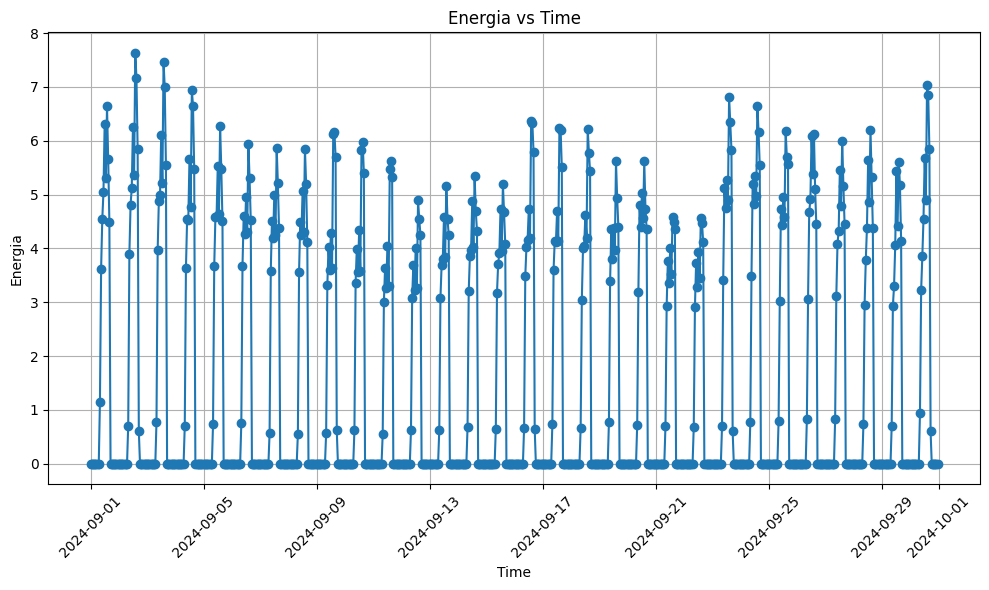

In [30]:
import matplotlib.pyplot as plt

# Plot the values of Energia against time
plt.figure(figsize=(10, 6))
plt.plot(submission_df['ds'], submission_df['Energia'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Energia')
plt.title('Energia vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
